In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from PIL import Image
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K

import cv2
import shutil
import glob
import os

In [2]:
from google.colab import drive
drive.mount('drive', force_remount=True)

Mounted at drive


In [3]:
data = '/content/drive/MyDrive/DCGANs/'
No_brain_tumor = '/content/drive/MyDrive/DCGANs/No'
Yes_brain_tumor = '/content/drive/MyDrive/DCGANs/Yes'

In [4]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  528    labels:  528


In [6]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(len(Files),2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/drive/MyDrive/DCGANs/No/Normal (104).jpg,No
1,/content/drive/MyDrive/DCGANs/No/Normal (110).jpg,No
2,/content/drive/MyDrive/DCGANs/No/Normal (129).jpg,No
3,/content/drive/MyDrive/DCGANs/No/Normal (116).jpg,No
4,/content/drive/MyDrive/DCGANs/No/Normal (105).jpg,No


In [7]:
print(df['labels'].value_counts())

Yes    294
No     234
Name: labels, dtype: int64


In [8]:
df = shuffle(df)

In [9]:
df.head()

,filepaths,labels
123,/content/drive/MyDrive/DCGANs/No/Normal (48).jpg,No
124,/content/drive/MyDrive/DCGANs/No/Normal (49).jpg,No
192,/content/drive/MyDrive/DCGANs/No/20.JPG,No
183,/content/drive/MyDrive/DCGANs/No/44.JPG,No
94,/content/drive/MyDrive/DCGANs/No/Normal (53).jpg,No


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 528 entries, 123 to 188
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  528 non-null    object
 1   labels     528 non-null    object
dtypes: object(2)
memory usage: 32.4+ KB


In [10]:
images = []
for filename in df['filepaths']:
  img=Image.open(filename)
  img = img.resize((128,128))
  img = np.array(img)
  img = (img.astype(np.float32) - 127.5)/127.5
  if len(img.shape) > 2 and img.shape[2] == 4:
      img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
  if len(img.shape) > 2 and img.shape[2] == 3:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  images.append(img)

images = np.array(images)

In [11]:
images.shape

(528, 128, 128)

In [21]:
images[0].shape

(128, 128)

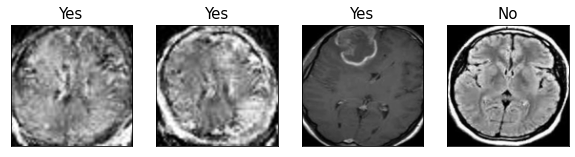

In [12]:
plt.figure(figsize=(10,8))
for i in range(4):
    random = np.random.randint(1,len(df))
    plt.subplot(1,4,i+1)
    plt.imshow(images[random], cmap='gray')
    plt.title(df.loc[random, "labels"], size = 15, color = "black") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [26]:
df['labels'].value_counts()

Yes    294
No     234
Name: labels, dtype: int64

In [28]:
df['labels'] = df['labels'].map({'Yes': 1, 'No': 0})

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, df['labels'], test_size=0.4)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5)

print(f"X_train set shape: {X_train.shape} y_train set shape: {y_train.shape}")
print(f"X_valid set shape: {X_valid.shape} y_valid set shape: {y_valid.shape}")
print(f"X_test set shape: {X_test.shape} y_test set shape: {y_test.shape}")

X_train set shape: (316, 128, 128) y_train set shape: (316,)
X_valid set shape: (106, 128, 128) y_valid set shape: (106,)
X_test set shape: (106, 128, 128) y_test set shape: (106,)


In [30]:
epochs = 10
batch_size = 10
input_shape = (128,128,1)

In [31]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(128,128,1)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)      

In [33]:
model.compile(loss="binary_crossentropy",
              optimizer='Adam',
              metrics=['accuracy'])

In [34]:
X_train = X_train.reshape(-1, 128, 128, 1)
X_valid = X_valid.reshape(-1, 128, 128, 1)
X_test = X_test.reshape(-1, 128, 128, 1)

In [35]:
print(X_train.shape, X_valid.shape, X_test.shape)

(316, 128, 128, 1) (106, 128, 128, 1) (106, 128, 128, 1)


In [36]:
hist = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_valid, y_valid))

Epoch 1/10
32/32 [==============================] - 11s 32ms/step - loss: 0.7018 - accuracy: 0.5380 - val_loss: 0.6634 - val_accuracy: 0.5189
Epoch 2/10
32/32 [==============================] - 0s 15ms/step - loss: 0.6140 - accuracy: 0.6741 - val_loss: 0.4706 - val_accuracy: 0.8302
Epoch 3/10
32/32 [==============================] - 1s 18ms/step - loss: 0.5083 - accuracy: 0.7500 - val_loss: 0.3594 - val_accuracy: 0.8679
Epoch 4/10
32/32 [==============================] - 0s 15ms/step - loss: 0.3756 - accuracy: 0.8354 - val_loss: 0.3102 - val_accuracy: 0.8679
Epoch 5/10
32/32 [==============================] - 1s 16ms/step - loss: 0.2672 - accuracy: 0.8956 - val_loss: 0.2750 - val_accuracy: 0.8962
Epoch 6/10
32/32 [==============================] - 1s 16ms/step - loss: 0.1820 - accuracy: 0.9272 - val_loss: 0.3048 - val_accuracy: 0.8679
Epoch 7/10
32/32 [==============================] - 0s 15ms/step - loss: 0.1666 - accuracy: 0.9335 - val_loss: 0.2687 - val_accuracy: 0.8585
Epoch 8/10
3

In [37]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


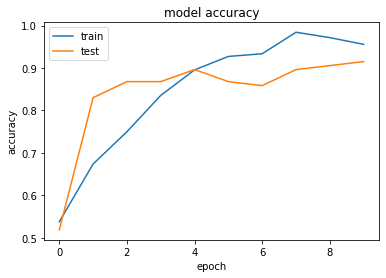

In [38]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

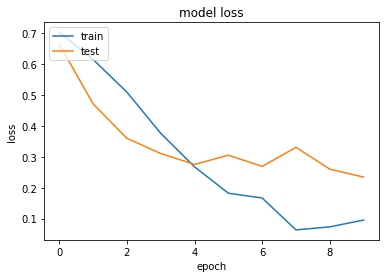

In [39]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

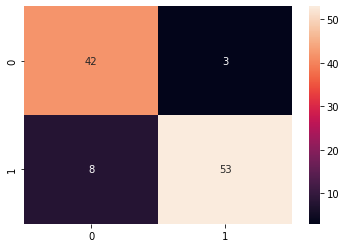

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

In [41]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8962264150943396



---



---

